In [1]:
import random

import numpy as np
import pandas as pd
import torch

try:
    import google.colab  # noqa: F401

    !pip install -q daml[torch] torchmetrics torchvision
    !export LC_ALL="en_US.UTF-8"
    !export LD_LIBRARY_PATH="/usr/lib64-nvidia"
    !export LIBRARY_PATH="/usr/local/cuda/lib64/stubs"
    !ldconfig /usr/lib64-nvidia
except Exception:
    pass

!pip install -q tabulate

import os

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"


np.random.seed(0)
np.set_printoptions(formatter={"float": lambda x: f"{x:0.4f}"})
torch.manual_seed(0)
torch.set_float32_matmul_precision("high")
device = "cuda" if torch.cuda.is_available() else "cpu"
torch._dynamo.config.suppress_errors = True

random.seed(0)
torch.use_deterministic_algorithms(True)
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"


import tensorflow_datasets as tfds

from daml.metrics.outlier import AEOutlier, VAEGMMOutlier
from daml.models.tensorflow import AE, VAEGMM, create_model


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


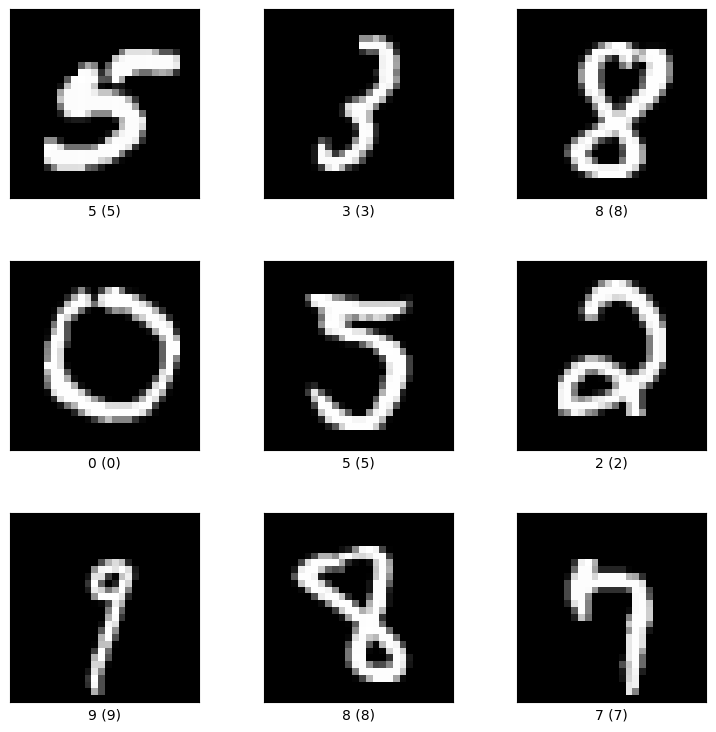

In [2]:
# Load in the mnist dataset from tensorflow datasets
(images, ds_info) = tfds.load(
    "mnist",
    split="train[:2000]",
    with_info=True,
)  # type: ignore

images = images.shuffle(images.cardinality())
tfds.visualization.show_examples(images, ds_info)
images = np.array([i["image"] for i in images], dtype=np.float32) / 255.0
input_shape = images[0].shape

In [3]:
detector = AEOutlier(create_model(AE, input_shape))
print(f"Training {detector.__class__.__name__}...")
detector.fit(images, threshold_perc=99, epochs=20, verbose=False)

Training AEOutlier...


In [4]:
# User-specified inputs

# What we use to curve-fit the sufficiency model
# train_ds = Subset(train_ds, range(2000))
# test_ds = Subset(test_ds, range(500))

target_performance = 0.97

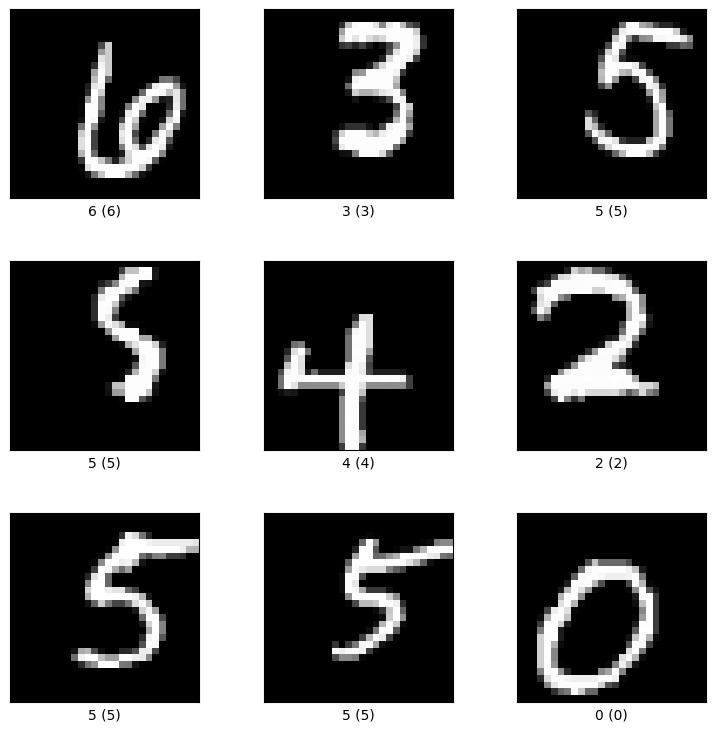

(2000, 28, 28, 1)


In [5]:
corr_images, ds_info = tfds.load(
    "mnist_corrupted/translate",
    split="train[:2000]",
    with_info=True,
)  # type: ignore

corr_images = corr_images.shuffle(corr_images.cardinality())
tfds.visualization.show_examples(corr_images, ds_info)
corr_images = np.array([i["image"] for i in corr_images], dtype=np.float32) / 255.0
# corr_images = corr_images.ravel().reshape((corr_images.shape[0], -1))
print(corr_images.shape)

In [6]:
# print([(type(detector).__name__, np.mean(detector.predict(images)["is_outlier"])) for detector in detectors])
# print([(type(detector).__name__, np.mean(detector.predict(corr_images)["is_outlier"])) for detector in detectors])
detector_output = detectors[0].predict(images)

In [7]:
num_ood = np.sum(detector_output["is_outlier"])
percent_ood = round(np.mean(detector_output["is_outlier"]), 3)
min_iscore = round(np.min(detector_output["instance_score"]), 3)
max_iscore = round(np.max(detector_output["instance_score"]), 3)
mean_iscore = round(np.mean(detector_output["instance_score"]), 3)
std_iscore = round(np.std(detector_output["instance_score"]), 3)

print(num_ood)
print(percent_ood)
print(min_iscore)
print(max_iscore)
print(mean_iscore)
print(std_iscore)

20
0.01
0.035
0.166
0.068
0.02


In [8]:
# Create a dictionary that gradient will plot as a table
ood_preds = {
    "num_ood": num_ood,
    "percent_ood": percent_ood,
    "min_iscore": min_iscore,
    "max_iscore": max_iscore,
    "mean_iscore": mean_iscore,
    "std_iscore": std_iscore,
}

In [9]:
from gradient.slide_deck.shapes import SubText, Table, Text, TextContent
from gradient.slide_deck.slidedeck import (
    DEFAULT_GRADIENT_PRESENTATION_TEMPLATE_PATH,
    DefaultGradientSlideLayouts,
    SlideDeck,
)


def generate_ood_report_table(ood_preds: dict) -> pd.DataFrame:
    ood_table = pd.DataFrame(
        {
            "Number of Outliers": [str(ood_preds["num_ood"])],
            "Percent Outliers in Dataset": [str(ood_preds["percent_ood"])],
            "Minimum Instance-Level Score": [str(ood_preds["min_iscore"])],
            "Maximum Instance-Level Score": [str(ood_preds["max_iscore"])],
            "Mean Instance-Level Score": [str(ood_preds["mean_iscore"])],
            "STDEV Instance-Level Score": [str(ood_preds["std_iscore"])],
        }
    )
    return ood_table


def generate_ood_report_slide_kwargs(ood_preds: dict) -> dict:
    content = [
        f"{ood_preds['percent_ood']*100}% of the dataset is out-of-distribution.",
    ]

    kwargs = {
        "title": "OOD Detection: Summary",
        "layout": DefaultGradientSlideLayouts.CONTENT_DEFAULT,
        "placeholder_fillings": [TextContent(lines=[Text(content=content)])],
        "additional_shapes": [
            Table(
                dataframe=generate_ood_report_table(ood_preds),
                fontsize=16,
                left=2.0,
                top=2.0,
                width=9.0,
                height=4.0,
            ),
        ],
    }
    return kwargs

In [10]:
from pathlib import Path

example_directory = Path.cwd() / "report_ood_example"
example_directory.mkdir(parents=True, exist_ok=True)

In [11]:
# Generate and add to the slide deck
deck = SlideDeck(presentation_template_path=DEFAULT_GRADIENT_PRESENTATION_TEMPLATE_PATH)

deck.add_slide(**generate_ood_report_slide_kwargs(ood_preds))

In [12]:
deck.save(
    output_directory=example_directory,
    name="report_ood_example",
)

PosixPath('/workspaces/daml/prototype/report_ood_example/report_ood_example_7.pptx')